# 3 QPSK, QAM

## Pythonのバージョン確認と，必要なライブラリをインポートする．

In [42]:
!python3 --version

import random

Python 3.7.13


In [ ]:
import matplotlib as makeMSL
import matplotlib.pyplot as plt
import numpy as np
import math

### 以下は$\mbox{erfc}$関数を読み込むためのライブラリ

In [ ]:
from scipy import special

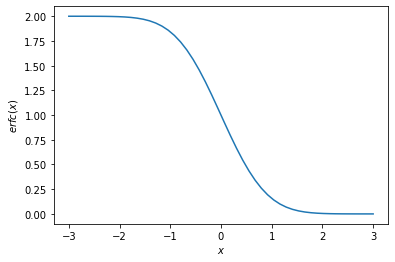

In [ ]:
x = np.linspace(-3, 3)
plt.plot(x, special.erfc(x))
plt.xlabel('$x$')
plt.ylabel('$erfc(x)$')
plt.show()

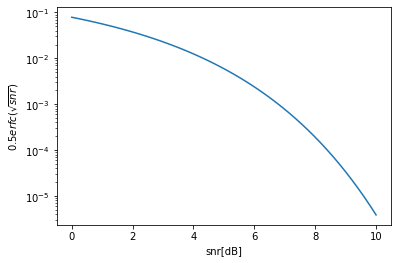

In [ ]:
snr = np.linspace(0, 10)
plt.plot(
    snr, 
    0.5 * special.erfc(
        np.sqrt(
            np.power(10, snr / 10.0 ) 
        )
    )
)
plt.yscale('log')
plt.xlabel('snr[dB]')
plt.ylabel('$0.5  erfc(\sqrt{snr})$')
plt.show()

## PSK等のための関数準備

### M系列を静的に作成する関数

In [ ]:
'''
  M系列を静的に作成する関数
  @param 略
  @return M系列 np
'''

def createMLS(
    N = 7, #次数
    a = 3, #帰還タップ
    b = 7, #帰還タップ
    X = 1000, # M系列の個数
):
  
  MLS = np.empty(X, dtype = int)

  for i in range(X) :
    if i < N :
      MLS[i] = random.randrange(2)
    else :
      MLS[i] = MLS[i - a] ^ MLS[i - b]

  return MLS


### M系列からデータを生成する


In [ ]:
'''
01配列から整数を返す関数
  @param bits                        01Numpy
  @return intBit                      整数
'''
def getIntFromBits(bits) :
  intBit = 0
  base = 1

  for i in range(bits.size):
    intBit += bits[bits.size - 1 - i] * base
    base *= 2
  
  return intBit

'''
  M系列からデータを生成する
  @param MLS                       元になるM系列データ
  @param bitNum                    生成データのビット数
  @return dataOrigin                 生成されたデータ     (元になるM系列データの大きさ) * （整数）
'''
def createData(MLS, bitNum = 1) : 
  #次のインデックス参照処理時に配列外参照を避けるため，同じM系列を２つもってきて長さ２倍に連結させる
  MLS2 = np.concatenate( [MLS, MLS] )

  return np.array(
      [  
          getIntFromBits( MLS2[ i : i + bitNum ] )
            for i in range( MLS.size )
      ],
      dtype = int
  )

#### 例

In [ ]:
#10個のM系列
MLSexample = createMLS(X = 10)

print("M系列")
print(MLSexample)

#２ビットのデータを生成
dataOriginExample = createData(
    MLSexample, bitNum= 2
  )

print("2ビットのデータ")
print( dataOriginExample )

M系列
[0 1 0 1 0 1 1 0 0 1]
2ビットのデータ
[1 2 1 2 1 3 2 0 1 2]


### PSK変調

BPSKの場合，$0 \mapsto -1, 1 \mapsto 1$とする． \\
QPSKの場合，データ$x$に対して$x \mapsto \exp[j (2  x + 1) \pi /4]$ \\
一般に多値数$M$に対してデータ$x$から偏角を$\frac{2\pi}{M}x$とすることを考える．

In [ ]:
'''
  0/1を-1/+1に復調
  @param dataOrigin     np もとの0/1データ
  @param encodeMode   str 復調方式
  @return dataEncoded   np -1/+1データ
'''

def encode(dataOrigin, encodeMode = "BPSK"):
  if encodeMode == "BPSK":
    dataEncoded = np.where( dataOrigin == 0, -1, 1 )
    return dataEncoded
  
  elif encodeMode == "QPSK":
    dataEncoded = np.exp(
        1j * (2 * dataOrigin + 1) * math.pi / 4.0
    )
    return dataEncoded

#### 例

In [ ]:
#10個のM系列
MLSexample = createMLS(X = 10)

print("M系列")
print(MLSexample)

#２ビットのデータを生成
dataOriginExample = createData(
    MLSexample, bitNum= 2
  )

print("2bitデータ")
print( dataOriginExample )

#QPSK
dataEncodedExample = encode(
        dataOriginExample, encodeMode = "QPSK"
        ) 
print("QPSK")
print( dataEncodedExample )

M系列
[1 0 0 1 0 0 0 1 0 0]
2bitデータ
[2 0 1 2 0 0 1 2 0 1]
QPSK
[-0.70710678-0.70710678j  0.70710678+0.70710678j -0.70710678+0.70710678j
 -0.70710678-0.70710678j  0.70710678+0.70710678j  0.70710678+0.70710678j
 -0.70710678+0.70710678j -0.70710678-0.70710678j  0.70710678+0.70710678j
 -0.70710678+0.70710678j]


### QAM(変調)


#### アルゴリズム

##### 16QAM

###### 信号配置の間の間隔

信号配置点を

$$\mathcal{S}_4 := \bigg\{ \pm I \pm j \  Q 
\bigg|
I, Q = a, 3a
\bigg\}$$

とおき，最大振幅を$A = 3\sqrt{2} a$とおく，平均電力$S$について第$１$象限を考えて，
\begin{align}
S &= \frac{1}{2} \cdot \frac{
  (a^2 + a^2) + 
  \big\{a^2 + (3a)^2\big\} + 
  \big\{(3a)^2 + a^2 \big\} + 
  \big\{ (3a)^2 + (3a)^2 \big\}
  }{4} \\
  &= 
  \frac{1}{2}\cdot2 \cdot 2 \cdot \frac{a^2 + (3a)^2}{4} \\
  &= 5a^2 = \frac{5}{18} A^2
\end{align}
である．これが$P_S = 1$のとき
$$
a = \frac{1}{\sqrt{5} }
$$
とわかる．

###### 信号点配置

$4$ビットのデータ$x_1 x_2 x_3 x_4$のうち上位$2$ビットを実部，下位$2$ビットを虚部として変調する．すなわち変調された信号を$s$とおくと

$$
s = a\big[2 (x_1 x_2) - 3\big] + j a\big[ 2 (x_3 x_4) - 3 \big]
$$

##### 64QAM

###### 信号配置の間の間隔

信号点配置を$$\mathcal{S}_{64} := \bigg\{ \pm I \pm j \  Q 
\bigg|
I, Q = a, 3a, 5a, 7a
\bigg\}$$

とおき，最大振幅を$A = 5\sqrt{2} a$とおく，平均電力$S$について第$1$象限を考えて，
\begin{align}
S &= \frac{1}{2} \cdot 2 \cdot 4 \cdot \frac{a^2 + (3a)^2 + (5a)^2 + (7a)^2}{16}
  \\
  &= 21a^2
\end{align}
である．これが$P_S = 1$のとき
$$
a = \frac{1}{\sqrt{21} }
$$
とわかる．

###### 信号配置

$6$ビットのデータ$x_1 x_2 x_3 x_4 x_5 x_6$のうち上位$3$ビットを実部，下位$3$ビットを虚部として変調する．すなわち変調された信号を$s$とおくと

$$
s = a\big[2 (x_1 x_2 x_3) - 7\big] + j a\big[ 2 (x_4 x_5 x_6) - 7 \big]
$$

##### 256QAM

###### 信号配置の間の間隔

信号点配置を$$\mathcal{S}_{256} := \bigg\{ \pm I \pm j \  Q 
\bigg|
I, Q = a, 3a, 5a, 7a, 9a, 11a, 13a, 15a
\bigg\}$$

とおき，最大振幅を$A = 15\sqrt{2} a$とおく，平均電力$S$について第$1$象限を考えて，
\begin{align}
S &= \frac{1}{2} \cdot 2 \cdot 16 \cdot \frac{a^2 + (3a)^2 + (5a)^2 + (7a)^2+
(9a)^2 + (11a)^2 + (13a)^2 + (15a)^2
}{64}
  \\
  &= 170a^2
\end{align}
である．これが$P_S = 1$のとき
$$
a = \frac{1}{\sqrt{170} }
$$
とわかる．

###### 信号配置

$8$ビットのデータ$x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8$のうち上位$4$ビットを実部，下位$4$ビットを虚部として変調する．すなわち変調された信号を$s$とおくと

$$
s = a\big[2 (x_1 x_2 x_3 x_4) - 15\big] + j a\big[ 2 (x_4 x_5 x_6) - 15 \big]
$$

#### 実装

In [ ]:
'''
  @param dataOrigin 変調する対象のデータ
  @param Mbit       多値数[bit] (= 2, 4, 6) 単位がビットであることに注意
  @return dataEncoded 変調されたデータ
'''
def encodeQAM(
    dataOrigin,
    Mbit,  
    P_S = 1
) :
  #信号点配置の間隔2aの半分a
  if Mbit == 4 :
    a = P_S / math.sqrt(5)
  elif Mbit == 6 :
    a = P_S / math.sqrt(21)
  elif Mbit == 8 :
    a = P_S / math.sqrt(170)
  
  #変調されたデータの実部
  dataOriginUpperBits = dataOrigin >> (Mbit//2)
  dataEncodedRealPart = a * ( 2 * dataOriginUpperBits - (Mbit//2 << 1) + 1 )

  #変調されたデータの虚部
  maskLowerBits = sum( [1 << bit for bit in range (Mbit//2)] )
  dataOriginLowerBits = dataOrigin & maskLowerBits
  dataEncodedImaginaryPart = a * ( 2 * dataOriginLowerBits - (Mbit//2 << 1) + 1 )

  #変調されたデータ全体
  dataEncoded = dataEncodedRealPart + 1j * dataEncodedImaginaryPart

  return dataEncoded

##### 例

4ビットデータ
[ 3  6 12  8  0  0  1  3  6 13 11  6 13 10  5 11  7 14 13 10  4  8  1  3
  6 12  9  2  4  8  1  2  4  8  0  0  0  1  2  4  9  2  4  9  3  6 13 10
  4  9  3  7 15 14 13 11  7 14 12  8  0  1  3  7 15 15 15 15 14 12  8  1
  3  7 14 13 11  6 12  8  1  2  5 10  4  9  2  5 11  7 15 15 14 13 10  5
 10  4  8  1]
16QAM
[-1.34164079+1.34164079j -0.4472136 +0.4472136j   1.34164079-1.34164079j
  0.4472136 -1.34164079j -1.34164079-1.34164079j -1.34164079-1.34164079j
 -1.34164079-0.4472136j  -1.34164079+1.34164079j -0.4472136 +0.4472136j
  1.34164079-0.4472136j   0.4472136 +1.34164079j -0.4472136 +0.4472136j
  1.34164079-0.4472136j   0.4472136 +0.4472136j  -0.4472136 -0.4472136j
  0.4472136 +1.34164079j -0.4472136 +1.34164079j  1.34164079+0.4472136j
  1.34164079-0.4472136j   0.4472136 +0.4472136j  -0.4472136 -1.34164079j
  0.4472136 -1.34164079j -1.34164079-0.4472136j  -1.34164079+1.34164079j
 -0.4472136 +0.4472136j   1.34164079-1.34164079j  0.4472136 -0.4472136j
 -1.34164079+0.4472136j  -0.

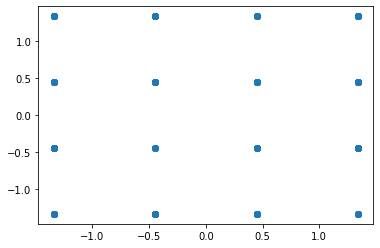

In [ ]:
#4ビットのデータを生成
dataOrigin4bitExample = createData(
    createMLS(X = 100), bitNum= 4
  )

print( "4ビットデータ" )
print( dataOrigin4bitExample )

#16QAM
dataEncodedQAMexample = encodeQAM( dataOrigin4bitExample, Mbit = 4)

print( "16QAM" )
print( dataEncodedQAMexample )

#図示
plt.scatter(
    dataEncodedQAMexample.real,
    dataEncodedQAMexample.imag
)
plt.show()

### ガウス確率変数をサンプリングする関数(Box-Muller法)

#### Box-Muller法の概要
一様分布に従う確率変数$x_1, x_2 \sim U(0,1)$を次の変換$(x_1, x_2) \mapsto (y_1, y_2)$を施すことで，変換先の確率変数は標準正規分布に従う．すなわち \\

$$
y_1 = \sqrt{
  -2 \ln{x_1}
} \cdot \cos 2 \pi x_2 \\
y_2 = \sqrt{
  -2 \ln{x_2}
} \cdot \sin 2 \pi x_1
$$
という変換に対して

$$
y_1, y_2 \sim \mathcal{N}(0, 1)
$$
となる．

また，平均$\mu$,分散$\sigma^2$のガウス分布$\mathcal{N}(\mu, \sigma^2)$に従う確率変数$z \sim \mathcal{N}(\mu, \sigma^2)$のサンプリングは
$$
z = \sigma \cdot y + \mu
$$
をとすることで十分.

#### サンプリング関数

In [ ]:
'''
ガウス分布に従う確率変数をサンプリングする
  @param mean    float     平均 
  @param variance float     分散

  @return gaussian float     ガウス分布に従う確率変数１つ(isComplex == Frue )
  @return gaussian complex ガウス分布に従う確率変数2つ(isComplex == True )
'''

def gaussianByBoxMuller(
    mean = 0.0,
    variance = 1.0,
    isComplex = False
) :
  #確率変数x_1, x_2 ~ U(0, 1)
  x_1 = random.uniform(0.0, 1.0)
  x_2 = random.uniform(0.0, 1.0)

  #確率変数x_1, x_2を変換して標準正規分布に従う確率変数y_1, y_2とする
  y_1 = math.sqrt(-2.0 * math.log(x_1)) * math.cos(2.0 * math.pi * x_2)
  y_2 = math.sqrt(-2.0 * math.log(x_2)) * math.sin(2.0 * math.pi * x_1)

  #するとy_1, y_2 ~ N(0, 1)になるので
  #G分布が欲しいならy_1 ~ N(0, 1), 
  #CN分布が欲しいならy = (y_1 + j *  y_2) ~ CN(0, 1)

  if isComplex == False :
    gaussian = math.sqrt( variance ) * y_1 + mean
    return gaussian

  else : 
    gaussianRealPart = math.sqrt( variance ) * y_1 + mean
    gaussianImaginaryPart = math.sqrt( variance ) * y_2 + mean

    gaussian =  gaussianRealPart + 1j * gaussianImaginaryPart
    
  return gaussian

### SNRから分散を計算する関数

$$
SNR [\mbox{dB}]  = 10 \log_{10} \frac{P_S}{P_N} = 10 \log_{10} \frac{1}{ 2 \sigma^2 }
$$
より
$$
\mbox{分散} \sigma^2 = \frac{1}{2} \cdot 10^{- \mbox{SNR}/10 }
$$

In [ ]:
def calcVarianceFromSNR(
    snr
):
  return 0.5 * math.pow(10.0, - snr / 10.0 )

### $\frac{ E_b }{ N_0 }$から分散を計算する関数

$$
\left\{
\begin{array}{ll}
P_S &= \log_2 M \times E_b \\
\frac{E_b}{N_0} &= 10 \log_{10} \Big( \frac{ E_b }{ 2 \sigma^2 } \Big) 
\end{array} 
\right.
$$

$$
\therefore \mbox{分散} \sigma^2 = \frac{P_S}{2 \log_2 M } 10^{
 - E_b/N_0 \big/ 10
}
$$


In [ ]:
'''
  @param EbN0 float １ビットあたりの電力と雑音の比
  @param P_S  float 送信電力
  @param Mbit 　int   多値数M[bit] 単位がビットであることに注意
'''
def calcVarianceFromEbN0(
    EbN0,
    P_S = 1,
    Mbit = 1
) :
  return (
      P_S /
      (2.0 * Mbit)
  ) * math.pow(10, - EbN0 / 10)

### PSK 復調
ノイズが乗った信号$y$を復調する． \\
BPSKの場合，$y$がマイナスなら$-1$として送られたと見なし，元のデータを$0$とする． $y$がプラスなら$+1$として送られたと見なし，元のデータを$1$とする． \\
すなわち
$$
\hat{x} = 
\left\{
\begin{array}{ll}
0  &  ( \mbox{if} \ y \leq 0 ) \\
1 & ( \mbox{otherwise}  )
\end{array} 
\right.
$$
である．


QPSKの場合$\exp\Big[j \frac{ (2  x + 1) \pi } { 4}\Big]\ (x = 0, 1, 2, 3)$とノルムが最も近いものを予測結果とする.すなわち，

$$
\hat{x} = \mbox{argmin}_{x \in \{ 0, 1, 2, 3 \} } \Bigg\| y - \exp\Big[j \frac{ (2  x + 1) \pi } { 4}\Big] \Bigg\|
$$

In [ ]:
'''
  受け取った信号を復調
  @param dataReceived  np 受け取ったデータ
  @param decodeMode   str 復調方式
  @return dataDecoded  np  データ
'''

def decode(dataReceived, decodeMode = "BPSK"):
  if decodeMode == "BPSK":
    dataDecoded = np.where( dataReceived <= 0, 0, 1 )
  
  elif decodeMode == "QPSK":
    simbolList = np.array([0, 1, 2, 3])
    
    dataDecoded = np.array([
        np.argmin(
            abs(
              data - 
              np.exp(1j * (2 * simbolList + 1) * math.pi / 4)
            )
        )
        for data in dataReceived
    ])

  return dataDecoded

#### 例

In [ ]:
#QPSK
print("元データ")
print( dataOriginExample )


print("QPSK")
print(dataEncodedExample)

#ノイズを載せる
dataReceivedExample = dataEncodedExample + gaussianByBoxMuller( 
    mean = 0.0,
    variance = 0.4,
    isComplex = True )

print("ガウスノイズを乗せたデータ")
print( dataReceivedExample )

#復調
dataDecodedExample = decode( dataReceivedExample,  "QPSK")

print("復調した結果")
print( dataDecodedExample )

元データ
[1 2 1 2 0 1 2 1 3 2]
QPSK
[-0.70710678+0.70710678j -0.70710678-0.70710678j -0.70710678+0.70710678j
 -0.70710678-0.70710678j  0.70710678+0.70710678j -0.70710678+0.70710678j
 -0.70710678-0.70710678j -0.70710678+0.70710678j  0.70710678-0.70710678j
 -0.70710678-0.70710678j]
ガウスノイズを乗せたデータ
[-1.43499952+0.81968543j -1.43499952-0.59452813j -1.43499952+0.81968543j
 -1.43499952-0.59452813j -0.02078596+0.81968543j -1.43499952+0.81968543j
 -1.43499952-0.59452813j -1.43499952+0.81968543j -0.02078596-0.59452813j
 -1.43499952-0.59452813j]
復調した結果
[1 2 1 2 1 1 2 1 2 2]


### QAM 復調
16QAMを例に挙げる． \\
受け取った信号$y$に対して信号候補$s(x) \in \mathcal{S}_{16}$と近いものを予測結果$\hat{x}$とする.すなわち

$$
\hat{x} = \mbox{arg min}_{x \in \{ 0,1,...,15\}}
\Bigg\| y - s(x) \Bigg\|
$$

In [ ]:
'''
  @param dataReceived np   受け取った信号
  @param Mbit          int   QAMの多値数[bit] 単位がビットであることに注意
  @param P_S          float 平均信号電力

  @return dataDecoded np   予測結果 
'''
def decodeQAM(
    dataReceived,
    Mbit,
    P_S = 1
) :
#信号点配置の間隔2aの半分a
  if Mbit == 4 :
    a = P_S / math.sqrt(5)
  elif Mbit == 6 :
    a = P_S / math.sqrt(21)
  elif Mbit == 8 :
    a = P_S / math.sqrt(170)

  #信号点候補
  symbolList = np.array([
      a * ( 2 * (symbol >> (Mbit//2)) - (Mbit//2 << 1) + 1 ) + 1j *
      a * ( 2 * (symbol & sum( [1 << bit for bit in range (Mbit//2)] ) ) - (Mbit//2 << 1) + 1 )
      for symbol in range(1 << Mbit)
  ])

  #信号予測
  dataDecoded = np.array([
        np.argmin(
            abs(data - symbolList ) 
        )
        for data in dataReceived
    ])

  return dataDecoded

### BER計算
送信したデータセットと，復調したデータセットの中身のうち正しく予測したものの割合

In [ ]:
'''
  BER
  @param dataOrigin    np   送信したデータセット
  @param dataDecoded np   予測したデータセット
  @param nonRated     bool 割合ではなく回数を返すかどうか
  @return               float ビット誤り率(BER: Bit Error Rate)
'''
def calcBER(
    dataOrigin,
    dataDecoded,
    nonRated = False
) : 
  if nonRated == False:
    return np.count_nonzero(
        dataOrigin != dataDecoded
    ) / dataOrigin.size
  
  else :
    return np.count_nonzero(
        dataOrigin != dataDecoded
    )

### 以上をまとめたSNRに対してBERを計算する関数
1. M系列を用いて送信データを作成する
2. 送信データを変調し，送信信号を作
成する
3. 平均 $0$ ，分散 $2σ^2$の白色ガウス雑音(Box-Mullerで
作った雑音)を送信信号に加え，受信信号とする
4. 受信信号を適当な変換により受信データに復調する
5. 受信データと送信データを比較し，ビット誤り率
(BER:Bit Error Rate)を算出する

In [ ]:
'''
  @param snr        SNR(信号対雑音電力比) [dB]
  @param dataSize  試行回数
  @return ber       ビット誤り率(BER: Bit Error Rate)
'''
def calcBERfromSNR(
    snr,
    mode,
    dataSize = 100000
) : 
  if mode == "QPSK":
    encodeMode = "QPSK"
    decodeMode = "QPSK"
    #M系列で送信データを作成
    MLS = createMLS(X = dataSize)
    dataOrigin = createData(MLS, bitNum = 2)

    #送信データXY( = 00, 01, 10, 11)をQPSKで変調し，送信信号を作成する
    dataEncoded = encode(dataOrigin, encodeMode)

    #平均０,分散2σ^2 の白色雑音(Box-Mullerで作った雑音)を送信信号に加え，受信信号とする
    dataReceived = dataEncoded + [
                      gaussianByBoxMuller(mean = 0.0, 
                                          variance = 1.0 * calcVarianceFromSNR(snr),
                                          isComplex = True)
                      for _ in range(dataSize)
                    ]

    #受信信号を00~11の受信データに復調する
    dataDecoded = decode(dataReceived, decodeMode)

    #受信データと送信データを比較し，ビット誤り率(BER:Bit Error Rate)を算出する
    ber = calcBER(dataOrigin, dataDecoded)


  if mode == "BPSK":
    encodeMode = "BPSK"
    decodeMode = "BPSK"
    #M系列で送信データを作成
    dataOrigin = createMLS(X = dataSize)

    #送信データの1を１，0を-1に変調し，送信信号を作成する
    dataEncoded = encode(dataOrigin, encodeMode = "BPSK")

    #平均０,分散2σ^2 の白色雑音(Box-Mullerで作った雑音)を送信信号に加え，受信信号とする
    dataReceived = dataEncoded + [
                      gaussianByBoxMuller(mean = 0.0, variance = 1.0 * calcVarianceFromSNR(snr) ) 
                      for _ in range(dataSize)
                    ]

    #受信信号を0と1の受信データに復調する
    dataDecoded = decode(dataReceived, decodeMode = "BPSK")

    #受信データと送信データを比較し，ビット誤り率(BER:Bit Error Rate)を算出する
    ber = calcBER( dataOrigin, dataDecoded)

  return ber

### PSK $E_b/N_0$に対してBERを計算する関数
1. M系列を用いて送信データを作成する
2. 送信データを変調し，送信信号を作成する
3. 平均 $0$ ，分散 $2σ^2$の白色ガウス雑音(Box-Mullerで
作った雑音)を送信信号に加え，受信信号とする
4. 受信信号を適当な変換により受信データに復調する
5. 受信データと送信データを比較し，ビット誤り率
(BER:Bit Error Rate)を算出する

In [ ]:
'''
  @param EbN0     1ビットあたりの電力と雑音の比 [dB]
  @param dataSize  試行回数
  @return ber       ビット誤り率(BER: Bit Error Rate)
'''
def calcBERfromEbN0(
    EbN0,
    mode,
    dataSize = 100000
) : 
  if mode == "QPSK":
    encodeMode = "QPSK"
    decodeMode = "QPSK"
    #M系列で送信データを作成
    MLS = createMLS(X = dataSize)
    dataOrigin = createData(MLS, bitNum = 2)

    #送信データXY( = 00, 01, 10, 11)をQPSKで変調し，送信信号を作成する
    dataEncoded = encode(dataOrigin, encodeMode)

    #平均０,分散2σ^2 の白色雑音(Box-Mullerで作った雑音)を送信信号に加え，受信信号とする
    dataReceived = dataEncoded + [
                      gaussianByBoxMuller(mean = 0.0, 
                                          variance = 1.0 * calcVarianceFromEbN0( EbN0 , Mbit = 2),
                                          isComplex = True)
                      for _ in range(dataSize)
                    ]

    #受信信号を00~11の受信データに復調する
    dataDecoded = decode(dataReceived, decodeMode)

    #受信データと送信データを比較し，ビット誤り率(BER:Bit Error Rate)を算出する
    ber = calcBER(dataOrigin, dataDecoded)


  if mode == "BPSK":
    encodeMode = "BPSK"
    decodeMode = "BPSK"
    #M系列で送信データを作成
    dataOrigin = createMLS(X = dataSize)

    #送信データの1を１，0を-1に変調し，送信信号を作成する
    dataEncoded = encode(dataOrigin, encodeMode = "BPSK")

    #平均０,分散2σ^2 の白色雑音(Box-Mullerで作った雑音)を送信信号に加え，受信信号とする
    dataReceived = dataEncoded + [
                      gaussianByBoxMuller(mean = 0.0, variance = 1.0 * calcVarianceFromEbN0( EbN0 , Mbit = 1) ) 
                      for _ in range(dataSize)
                    ]

    #受信信号を0と1の受信データに復調する
    dataDecoded = decode(dataReceived, decodeMode = "BPSK")

    #受信データと送信データを比較し，ビット誤り率(BER:Bit Error Rate)を算出する
    ber = calcBER( dataOrigin, dataDecoded)

  return ber

In [ ]:
'''
  @param EbN0     1ビットあたりの電力と雑音の比 [dB]
  @param dataSize  試行回数
  @return ber       ビット誤り率(BER: Bit Error Rate)
'''
def calcBERfromEbN0(
    EbN0,
    mode,
    dataSize = 100000
) : 
  if mode == "QPSK":
    encodeMode = "QPSK"
    decodeMode = "QPSK"
    #M系列で送信データを作成
    MLS = createMLS(X = dataSize)
    dataOrigin = createData(MLS, bitNum = 2)

    #送信データXY( = 00, 01, 10, 11)をQPSKで変調し，送信信号を作成する
    dataEncoded = encode(dataOrigin, encodeMode)

    #平均０,分散2σ^2 の白色雑音(Box-Mullerで作った雑音)を送信信号に加え，受信信号とする
    dataReceived = dataEncoded + [
                      gaussianByBoxMuller(mean = 0.0, 
                                          variance = 1.0 * calcVarianceFromEbN0( EbN0 , Mbit = 2),
                                          isComplex = True)
                      for _ in range(dataSize)
                    ]

    #受信信号を00~11の受信データに復調する
    dataDecoded = decode(dataReceived, decodeMode)

    #受信データと送信データを比較し，ビット誤り率(BER:Bit Error Rate)を算出する
    ber = calcBER(dataOrigin, dataDecoded)


  if mode == "BPSK":
    encodeMode = "BPSK"
    decodeMode = "BPSK"
    #M系列で送信データを作成
    dataOrigin = createMLS(X = dataSize)

    #送信データの1を１，0を-1に変調し，送信信号を作成する
    dataEncoded = encode(dataOrigin, encodeMode = "BPSK")

    #平均０,分散2σ^2 の白色雑音(Box-Mullerで作った雑音)を送信信号に加え，受信信号とする
    dataReceived = dataEncoded + [
                      gaussianByBoxMuller(mean = 0.0, variance = 1.0 * calcVarianceFromEbN0( EbN0 , Mbit = 1) ) 
                      for _ in range(dataSize)
                    ]

    #受信信号を0と1の受信データに復調する
    dataDecoded = decode(dataReceived, decodeMode = "BPSK")

    #受信データと送信データを比較し，ビット誤り率(BER:Bit Error Rate)を算出する
    ber = calcBER( dataOrigin, dataDecoded)

  return ber

### QAM $E_b/N_0$に対してBERを計算する関数

In [ ]:
'''
  @param EbN0     1ビットあたりの電力と雑音の比 [dB]
  @param Mbit      多値数[bit] 単位がビットであることに注意
  @param dataSize  試行回数
  @return ber       ビット誤り率(BER: Bit Error Rate)
'''
def calcBERfromEbN0ByQAM(
    EbN0,
    Mbit,
    dataSize = 100000,
    debugMode = False
) : 
  #M系列で送信データを作成
  MLS = createMLS(X = dataSize)
  dataOrigin = createData(MLS, bitNum = Mbit)

  #送信データをQPSKで変調し，送信信号を作成する
  dataEncoded = encodeQAM(dataOrigin, Mbit)

  #平均０,分散2σ^2 の白色雑音(Box-Mullerで作った雑音)を送信信号に加え，受信信号とする
  dataReceived = dataEncoded + [
                    gaussianByBoxMuller(mean = 0.0, 
                                        variance = 1.0 * calcVarianceFromEbN0( EbN0, Mbit ),
                                        isComplex = True)
                    for _ in range(dataSize)
                  ]

  #受信信号を復調する
  dataDecoded = decodeQAM(dataReceived, Mbit)

  #受信データと送信データを比較し，ビット誤り率(BER:Bit Error Rate)を算出する
  ber = calcBER(dataOrigin, dataDecoded, debugMode)

  return ber

## 1 Simulation of PQSK

### パラメータ

In [49]:
#試行回数
X = 1000000

#SNR 0 ~ 10[dB]
SNR_MIN = 0
SNR_MAX = 10



In [50]:
#定義域(SNR)
N = (SNR_MAX - SNR_MIN) * 10
SNR = np.linspace(SNR_MIN, SNR_MAX, N)


### 1.1 SNR
横軸 SNR:0∼10 [dB]，縦軸 BER(対数表示 %e)のグラフを描く.

#### 実行結果

In [51]:
#値域(BER)
BER_QPSK_SNR = [ calcBERfromSNR(
    snr = SNR[n],
    mode = "QPSK",
    dataSize = X
    ) 
for n in range (N) ]

np.savetxt('BER_QPSK_SNR.csv', BER_QPSK_SNR)

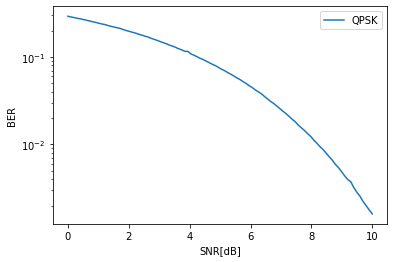

In [53]:
plt.plot(
    SNR,
    np.loadtxt('BER_QPSK_SNR.csv', delimiter = ','),
    label = "QPSK"
)


plt.yscale('log')

plt.xlabel("SNR[dB]")
plt.ylabel("BER")

plt.legend()

plt.savefig("BER_SNR_QPSK.png")

plt.show()

### 1.2 $E_b/N_0$
横軸 Eb/N0:0∼10 [dB]，縦軸 BER(%e)のグラフを描く.

In [60]:
#試行回数
X = 1000000

#EbN0 0 ~ 10[dB]
EbN0_MIN = 0
EbN0_MAX = 30

In [57]:
#定義域(EbN0)
N = (EbN0_MAX - EbN0_MIN) * 10
EbN0 = np.linspace(EbN0_MIN, EbN0_MAX, N)


#### 実行結果

In [61]:
BER_QPSK_EbN0 = [
    calcBERfromEbN0(
        EbN0 = EbN0[n],
        mode = "QPSK",
        dataSize = X
    )
    for n in range(N)
]

np.savetxt('BER_QPSK_EbN0.csv', BER_QPSK_EbN0)

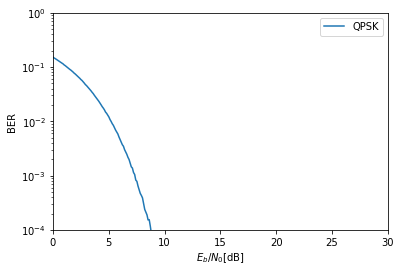

In [62]:
plt.plot(
    EbN0,
    np.loadtxt('BER_QPSK_EbN0.csv', 
                                delimiter = ','),
    label = "QPSK"
)


plt.yscale('log')

plt.xlim( 0, 30 )
plt.ylim( 10 ** (-4), 1 )

plt.xlabel("$E_b/N_0$[dB]")
plt.ylabel("BER")

plt.legend()

plt.savefig("BER_QPSK_EbN0.png")


plt.show()

## 2 M-QAM

### パラメータ

In [ ]:
#試行回数
X = 1000000

#EbN0 0 ~ 10[dB]
EbN0_MIN = 0
EbN0_MAX = 30

In [ ]:
#定義域(EbN0)
N = (EbN0_MAX - EbN0_MIN) * 10
EbN0 = np.linspace(EbN0_MIN, EbN0_MAX, N)


### 実行

In [ ]:
#16QAM
BER_16QAM_EbN0 = [
    calcBERfromEbN0ByQAM(
        EbN0 = EbN0[n],
        Mbit = 4,
        dataSize = X,
    )
    for n in range(N)
]

np.savetxt('BER_16QAM_EbN0.csv', BER_16QAM_EbN0)

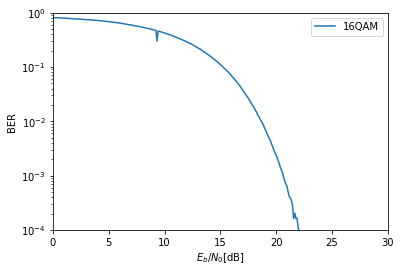

In [ ]:
#16QAMの実行結果
plt.plot(
    EbN0,
    np.loadtxt('BER_16QAM_EbN0.csv', 
                                delimiter = ','),
    label = "16QAM"
)

plt.yscale('log')

plt.xlim( 0, 30 )
plt.ylim( 10 ** (-4), 1 )

plt.xlabel("$E_b/N_0$[dB]")
plt.ylabel("BER")

plt.legend()

plt.savefig("16QAM_BER_EbN0.png")

plt.show()

In [ ]:
#64QAM

#時間がかかるので0~30[dB]のEbN0を0~10, 10~20, 20~30に分けて実行する

#0~10[dB]
BER_64QAM_EbN0_01 = [
    calcBERfromEbN0ByQAM(
        EbN0 = EbN0[n],
        Mbit = 6,
        dataSize = X
    )
    for n in range(0, N // 3)
]

np.savetxt('BER_64QAM_EbN0_01.csv', BER_64QAM_EbN0_01)

In [ ]:
#10~20[dB]
BER_64QAM_EbN0_02 = [
    calcBERfromEbN0ByQAM(
        EbN0 = EbN0[n],
        Mbit = 6,
        dataSize = X
    )
    for n in range(N // 3, (2 * N) // 3)
]

np.savetxt('BER_64QAM_EbN0_02.csv', BER_64QAM_EbN0_02)

In [35]:
#20~30[dB]
BER_64QAM_EbN0_03 = [
    calcBERfromEbN0ByQAM(
        EbN0 = EbN0[n],
        Mbit = 6,
        dataSize = X
    )
    for n in range((2 * N) // 3, N)
]

np.savetxt('BER_64QAM_EbN0_03.csv', BER_64QAM_EbN0_03)

In [38]:
#結合
BER_64QAM_EbN0_01_ = np.loadtxt('BER_64QAM_EbN0_01.csv', delimiter = ',')
BER_64QAM_EbN0_02_ = np.loadtxt('BER_64QAM_EbN0_02.csv', delimiter = ',')
BER_64QAM_EbN0_03_ = np.loadtxt('BER_64QAM_EbN0_03.csv', delimiter = ',')

BER_64QAM_EbN0 = np.concatenate(
    (
    BER_64QAM_EbN0_01_,
    BER_64QAM_EbN0_02_,
    BER_64QAM_EbN0_03_
     )
)

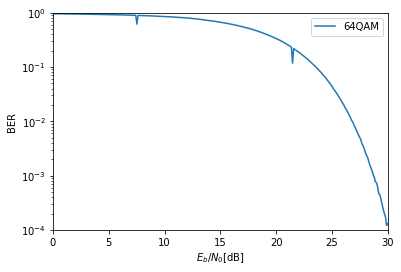

In [39]:
#64QAMの実行結果
plt.plot(
    EbN0,
    BER_64QAM_EbN0,
    label = "64QAM"
)


plt.xlim( 0, 30 )
plt.ylim( 10 ** (-4), 1 )

plt.yscale('log')

plt.xlabel("$E_b/N_0$[dB]")
plt.ylabel("BER")

plt.legend()

plt.savefig("64QAM_BER_EbN0.png")

plt.show()

In [41]:
#256QAM

#時間がかかるので0~30[dB]のEbN0を0~10, 10~20, 20~30に分けて実行する

#0~10[dB]
BER_256QAM_EbN0_01 = [
    calcBERfromEbN0ByQAM(
        EbN0 = EbN0[n],
        Mbit = 8,
        dataSize = X
    )
    for n in range(0, N // 3)
]

np.savetxt('BER_256QAM_EbN0_01.csv', BER_256QAM_EbN0_01)

In [43]:
#10~20[dB]
BER_256QAM_EbN0_02 = [
    calcBERfromEbN0ByQAM(
        EbN0 = EbN0[n],
        Mbit = 8,
        dataSize = X
    )
    for n in range(N // 3, (N * 2) // 3)
]

np.savetxt('BER_256QAM_EbN0_02.csv', BER_256QAM_EbN0_02)

In [44]:
#20~30[dB]
BER_256QAM_EbN0_03 = [
    calcBERfromEbN0ByQAM(
        EbN0 = EbN0[n],
        Mbit = 8,
        dataSize = X
    )
    for n in range( (2 * N) // 3, N)
]

np.savetxt('BER_256QAM_EbN0_03.csv', BER_256QAM_EbN0_03)

In [45]:
#結合
BER_256QAM_EbN0_01_ = np.loadtxt('BER_256QAM_EbN0_01.csv', delimiter = ',')
BER_256QAM_EbN0_02_ = np.loadtxt('BER_256QAM_EbN0_02.csv', delimiter = ',')
BER_256QAM_EbN0_03_ = np.loadtxt('BER_256QAM_EbN0_03.csv', delimiter = ',')

BER_256QAM_EbN0 = np.concatenate(
    (
    BER_256QAM_EbN0_01_,
    BER_256QAM_EbN0_02_,
    BER_256QAM_EbN0_03_
     )
)

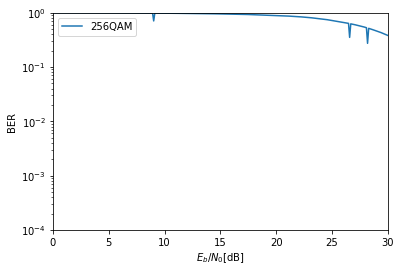

In [46]:
#256QAMの実行結果
plt.plot(
    EbN0,
    BER_256QAM_EbN0,
    label = "256QAM"
)


plt.xlim( 0, 30 )
plt.ylim( 10 ** (-4), 1 )

plt.yscale('log')

plt.xlabel("$E_b/N_0$[dB]")
plt.ylabel("BER")

plt.legend()

plt.savefig("256QAM_BER_EbN0.png")

plt.show()

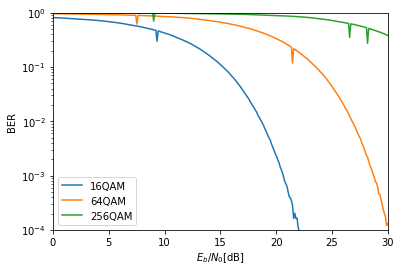

In [47]:
#16QAM, 64QAM, 256QAMのBER-Eb/N0グラフ

plt.plot(
    EbN0,
    BER_16QAM_EbN0,
    label = "16QAM"
)

plt.plot(
    EbN0,
    BER_64QAM_EbN0,
    label = "64QAM"
)

plt.plot(
    EbN0,
    BER_256QAM_EbN0,
    label = "256QAM"
)


plt.xlim( 0, 30 )
plt.ylim( 10 ** (-4), 1 )


plt.yscale('log')

plt.xlabel("$E_b/N_0$[dB]")
plt.ylabel("BER")

plt.legend()

plt.savefig("MQAM_BER_EbN0.png")

plt.show()